In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)

In [7]:
housing_df = pd.read_csv("austinHousingData.csv")
df = housing_df.copy()

df = df.drop(columns=['zpid','streetAddress','description','homeImage'])


In [8]:
y = df['latestPrice']
X = df.drop(columns=['latestPrice', 'city', 'zipcode'])

print("Features:", X.shape, "Target:", y.shape)

Features: (15171, 40) Target: (15171,)


In [9]:
numeric_cols = X.select_dtypes(include=['int64','float64','bool']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])



In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
pipe_knn = Pipeline(steps=[
    ('prep', preprocessor),
    ('knn', KNeighborsRegressor())
])

param_grid = {
    'knn__n_neighbors': [5, 10, 15, 20],
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)
print("Best parameters:", grid_knn.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}


In [15]:
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

rmse_knn = root_mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN RMSE: ${rmse_knn:,.2f}")
print(f"KNN R2: {r2_knn:.4f}")


KNN RMSE: $360,490.15
KNN R2: 0.4509


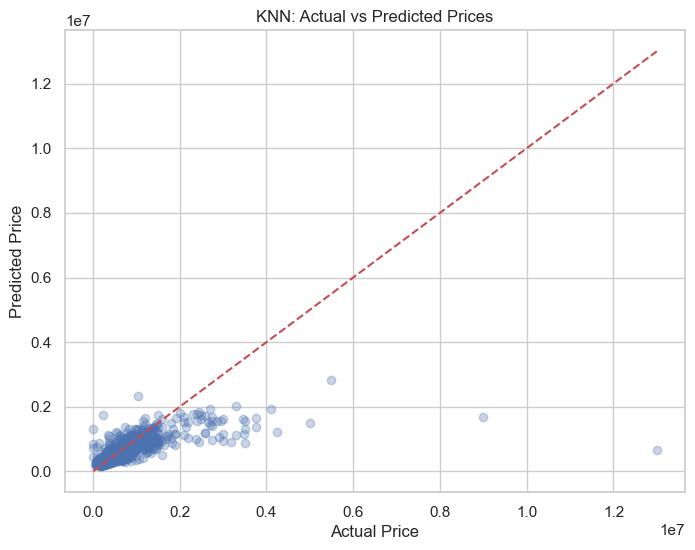

In [14]:
plt.scatter(y_test, y_pred_knn, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('KNN: Actual vs Predicted Prices')
plt.show()

- used 5 fold cross-validation and grid search to tune `n_neighbors`, `metric`, and `weights`.  
- Best KNN parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}  
- Performance: RMSE = $360,490.15, R2 = 0.4509.  
- compared to Gradient Boosting (tuned RMSE ≈ $317K, R2 ≈ 0.574), KNN highlights local neighborhood effects but underperforms global ensemble methods.  
- overfitting control: Using `weights='distance'` and a moderate `k=10` reduced variance.  
- EDA insights: Scaling wit critical features like `livingAreaSqFt` and `lotSizeSqFt` showed skew and needed normalization before distance based modeling.  
- Unexpected: Manhattan distance performed on par with Euclidean, suggesting that price similarity depends on a combination of features rather than pure spatial proximity.